# VANILLA GAN - MNIST

## IMPORTS

In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import os
import time

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [3]:
# torch.cuda.get_device_name(0)

## HYPERPARAMETERS

In [4]:
dataroot = '../storage/data/mnist_png/'
saveroot = '../storage/GAN_Images/'
test_number = 'Test_1'

batch_size = 32
workers = 4
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(1),
    torchvision.transforms.ToTensor()
])

nz = 100

lr = 0.00005
is_emd = True ## WGAN ##

num_epochs = 100
num_steps = 1000
k = 5

## DATASET

In [5]:
ds = torchvision.datasets.ImageFolder(dataroot+'training', transforms)

In [6]:
len(ds)

60000

In [7]:
dl = torch.utils.data.DataLoader(ds, batch_size, shuffle=True, num_workers=workers, pin_memory=True)

## DATA ANALYSIS

In [8]:
for data in (dl):
    print(data[0].shape, data[1].shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


## MODEL

In [9]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(nz, 256),
            torch.nn.LeakyReLU(0.2)
        )
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.LeakyReLU(0.2)
        )
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(512, 1024),
            torch.nn.LeakyReLU(0.2)
        )
        self.fc4 = torch.nn.Sequential(
            torch.nn.Linear(1024, 784),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        # x.shape = batch_size x nz
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [10]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(784 , 1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(1024 , 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(512 , 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3)
        )
        self.fc4 = torch.nn.Sequential(
            torch.nn.Linear(256 , 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        # (batch_size, 784) or (batch_size, 1, 28, 28)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x ## WGAN ##

In [11]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [12]:
for params in discriminator.parameters():
    print(params.shape)

torch.Size([1024, 784])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([1, 256])
torch.Size([1])


## LOSS AND OPTIMIZATION

In [13]:
opt_d = torch.optim.RMSprop(discriminator.parameters(), lr) ## WGAN ##
opt_g = torch.optim.RMSprop(generator.parameters(), lr) ## WGAN ##
criterion = torch.nn.KLDivLoss() ## WGAN ##

In [14]:
real_labels = torch.ones((batch_size, 1)).to(device)
fake_labels = (-1 * torch.ones((batch_size, 1))).to(device) ## WGAN ##
fixed_noise = torch.randn(batch_size, nz).to(device)

## PRE-TRAIN RUN

In [15]:
with torch.no_grad():
    #REAL BATCH
    for xb, _ in dl:
        sample = xb.to(device)
        break
    print(sample.shape)
    out = discriminator(sample)
    print(out.shape)
    loss = criterion(out, real_labels)
    print(loss)
    #FAKE BATCH
    sample = generator(fixed_noise)
    print(sample.shape)
    out = discriminator(sample)
    print(out.shape)
    loss = criterion(out, real_labels)
    print(loss)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1])
tensor(-0.5030, device='cuda:0')
torch.Size([32, 784])
torch.Size([32, 1])
tensor(-0.5059, device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


## TRAIN

In [16]:
def train_discriminator(images):
    ## WGAN ##
    for p in discriminator.parameters():
        p.data.clamp_(-0.01, 0.01)
        
    opt_d.zero_grad()
    
    real_images = images.to(device)
    fake_images = generator(torch.randn(batch_size, nz).to(device))
    
    real_out = discriminator(real_images)
    fake_out = discriminator(fake_images)
    
    ## WGAN ##
    if is_emd:
        real_out = real_out.mean(0).view(1)
        fake_out = fake_out.mean(0).view(1)
        real_out.backward(real_labels)
        fake_out.backward(fake_labels)
        
        return (real_out - fake_out).item()
        
    else:
        real_loss = criterion(real_out, real_labels)
        fake_loss = criterion(fake_out, fake_labels)
        real_loss.backward()
        fake_loss.backward()
        
        return (real_loss + fake_loss).item()

In [17]:
def train_generator():
    opt_g.zero_grad()

    out = discriminator(generator(torch.randn(batch_size, nz).to(device)))
    
    ## WGAN ##
    if is_emd:
        out = out.mean().mean(0).view(1)
        out.backward(real_labels)
        return -1*out.item()
    else:
        loss = criterion(out, real_labels)
        loss.backward()
    
        return loss.item()

In [18]:
start_time = time.time()
loss_D = []
loss_G = []

for epoch in range(num_epochs):
    epoch += 1
    loss_d = 0.0
    loss_g = 0.0
    
    for i,(images,_) in enumerate(dl):
        if i == num_steps:
            break
            
        for _ in range(k):
            loss_d += train_discriminator(images)
            opt_d.step()
        loss_g += train_generator()
        opt_g.step()
    loss_D.append(loss_d / k / i)
    loss_G.append(loss_g / i)
    
    print(f'{epoch}/{num_epochs} | loss_d: {loss_d/k/i} | loss_g: {loss_g/i} | Time: {time.time() - start_time:.0f} sec')
    if epoch%10==0:
        sample = generator(fixed_noise).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=8, pad_value=1, normalize=False)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, '20210126_MNIST_WGAN_{}_{}.jpg'.format(str(test_number), str(epoch).zfill(3))))

1/100 | loss_d: -0.4250073119521141 | loss_g: -0.5951452454328537 | Time: 27 sec
2/100 | loss_d: -0.394642234057188 | loss_g: -0.6068307523727416 | Time: 52 sec
3/100 | loss_d: -0.3532959159523249 | loss_g: -0.6046999133229256 | Time: 78 sec
4/100 | loss_d: -0.3195822525411844 | loss_g: -0.6095139250457287 | Time: 104 sec
5/100 | loss_d: -0.29973046661019326 | loss_g: -0.6220934563875198 | Time: 130 sec
6/100 | loss_d: -0.2788818301141262 | loss_g: -0.6221330229043961 | Time: 156 sec
7/100 | loss_d: -0.25494629368484023 | loss_g: -0.6133812649846077 | Time: 182 sec
8/100 | loss_d: -0.23698006897568702 | loss_g: -0.6109957805871964 | Time: 212 sec
9/100 | loss_d: -0.21603507826030255 | loss_g: -0.6014423681199551 | Time: 239 sec
10/100 | loss_d: -0.19793472092151643 | loss_g: -0.600027548789978 | Time: 265 sec
11/100 | loss_d: -0.17972498405575751 | loss_g: -0.5907938641905784 | Time: 291 sec
12/100 | loss_d: -0.16665750343203545 | loss_g: -0.579804741114378 | Time: 316 sec
13/100 | los

## TEST

## EVALUATE

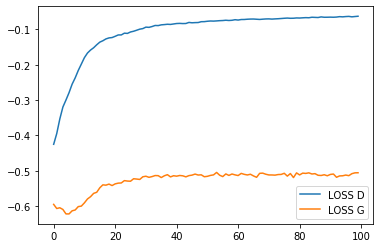

In [19]:
plt.figure()

plt.plot(loss_D, label='LOSS D')
plt.plot(loss_G, label='LOSS G')
plt.legend()
plt.savefig('./20210126_MNIST_WGAN_{}'.format(test_number))
plt.show()

## SAVE/ LOAD

In [20]:
torch.save(generator.state_dict(), './20210126_MNIST_WGAN_G.pt')
torch.save(discriminator.state_dict(), './20210126_MNIST_WGAN_D.pt')